In [1]:
from tensorflow.keras.models import load_model
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.backend as K
import keras

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.test.is_gpu_available())
print('-'*30)
print(tf.test.gpu_device_name())
print('-'*30)
print(tf.config.list_physical_devices('GPU'))
print('-'*30)
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
------------------------------
/device:GPU:0
------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6691814995680070729
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10317004800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16096883899552078305
physical_device_desc: "device: 0, name: NVIDIA TITAN V, pci bus id: 0000:01:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [3]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [4]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def scaleImg(img, height, width):
    return cv2.resize(img, dsize = (width, height), interpolation = cv2.INTER_LINEAR)


def normalizeImageIntensityRange(img):
    HOUNSFIELD_MIN = np.min(img)
    HOUNSFIELD_MAX = np.max(img)
    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN
    
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

def normalize_image(img,low_p=0,up_p=100):
    min_ = np.percentile(img.flatten(),low_p)
    max_ = np.percentile(img.flatten(),up_p)
    if min_ == max_ and max_ > 0:
        return (img - min_) / (max_ - min_)
    elif min_ == max_ and max_ == 0:
        return img
    else:
        new_img  = (img - min_) / (max_ - min_)
        new_img[new_img > 1] = 1
        new_img[new_img < 0] = 0

        return new_img

In [5]:
model_dir = 'liverseg_mri6E_nodropout_drsn_augment_histeq_individualEcho_refinewithmultimodal_02262018v2'
weight_dir = 'retrain2_Data_0_8e-05_1_1_0_6461.hdf5'
model = load_model(model_dir, custom_objects={'jacc_dist': jacc_dist, 'dice_coef': dice_coef})
model.load_weights(weight_dir)

In [5]:
model = load_model('V5_2D_UNET_LIG_IDEAL_first20_L7_H256_W256.h5', custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

In [174]:
targetImagePath = r'N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE\A005.nii'

imgTargetNii = nib.load(targetImagePath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())

imgTarget = np.flip(np.rot90(imgTarget), 1)

In [106]:
imgTarget.shape, imgTarget.max(), imgTarget.min()

((256, 256, 24), 1.0, 0.0)

In [126]:
test = imgTarget[:,:,8]

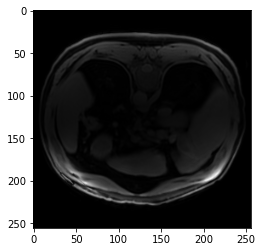

In [127]:
plt.imshow(test, cmap='gray')
plt.show()

In [128]:
test.max()

0.7042835398999783

In [129]:
test = normalizeImageIntensityRange(test)
test.max()

1.0

In [130]:
test = test
test.max(), test.min()

(1.0, 0.0)

In [131]:
test = np.flip(np.flip(np.uint8(test * 255), 0), 1)
cv2.imwrite('test.png', test)

True

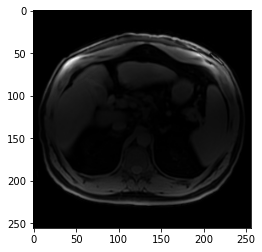

In [132]:
plt.imshow(test, cmap='gray')
plt.show()

In [133]:
test.shape

(256, 256)

In [99]:
from scipy.ndimage.interpolation import zoom

s0,s1 = test.shape

test = zoom(test, (224/s0,224/s1))
test.shape

(224, 224)

In [134]:
test = np.expand_dims(normalize_image(test,0,100), -1)
test.shape

(256, 256, 1)

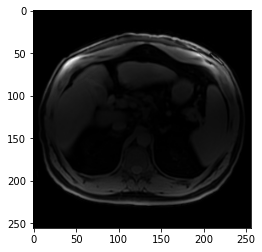

In [135]:
plt.imshow(test, cmap='gray')
plt.show()

In [136]:
test = np.expand_dims(test, 0)
test.shape

(1, 256, 256, 1)

In [137]:
pred = model.predict(test)
pred.shape

(1, 256, 256, 1)

In [138]:
pred.max()

0.9986534

In [139]:
pred = pred[0,:,:,:]
pred.shape

(256, 256, 1)

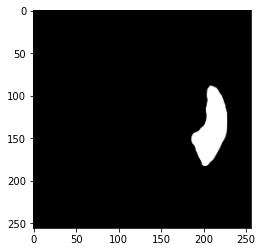

In [142]:
plt.imshow(pred, cmap='gray')
plt.show()

In [124]:
pred_ni = nib.Nifti1Image(pred, imgTargetNii.affine)

In [125]:
nib.save(pred_ni, 'test.nii')

In [175]:
imgTarget.shape

(256, 256, 28)

In [176]:
imgTarget = normalizeImageIntensityRange(imgTarget)
imgTarget.max()

1.0

In [177]:
pred1 = np.zeros((256, 256, imgTarget.shape[2]))
pred1.shape

(256, 256, 28)

In [178]:
for i in range(imgTarget.shape[2]):
    img = np.flip(np.flip(imgTarget[:,:,i],0),1)
    img1 = np.expand_dims(np.expand_dims(normalize_image(img,0,100), 0), -1)
    pred = model.predict(img1)
    pred[pred >= 0.5] = 1; pred[pred < 0.5] =0
    pred = pred[0, :, :, 0]
    pred1[:,:,i] = pred

In [179]:
pred1.shape

(256, 256, 28)

In [180]:
pred_ni = nib.Nifti1Image(np.rot90(np.flip(pred1, 0), 3), imgTargetNii.affine)

In [181]:
nib.save(pred_ni, 'test.nii')